# Cartpole



The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & \pi & 0
    \end{bmatrix}
\end{equation*}
$$

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
torch.set_num_threads(1)
torch.set_flush_denormal(True)
import numpy as np

In [6]:
DT = 0.1  # Time step (s).
RENDER = True  # Whether to render the environment or not.
N = 25 # Planning horizon length.
H = 4 * N  # Episode length.
U_MAX = torch.tensor([10.0])  # Maximum action.
U_MIN = -U_MAX  # Minimum action.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.cartpole.CartpoleCost()
model = pddp.examples.cartpole.CartpoleDynamicsModel(DT)
env = pddp.examples.cartpole.CartpoleEnv(dt=DT, render=RENDER)

/usr/local/data/miniconda3/envs/pddp/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [8]:
def plot(Z, U):
    t = np.arange(Z.shape[0]) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = U.detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta_dot = X[:, 3]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, state, Z, U, J_opt):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    final_state = Z[-1].detach().numpy()
    final_state[2] = (final_state[2] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, state, J_opt, final_state)

In [10]:
controller = pddp.controllers.iLQRController(env, model, cost)

In [11]:
U = 1e-1 * torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
env.reset()
Z, U, state = controller.fit(U, encoding=ENCODING, n_iterations=1, tol=0,
                             on_iteration=on_iteration, u_min=U_MIN, u_max=U_MAX)


iteration 1 iLQRState.REJECTED 29.289173 [ 0.09607116  0.02405791 -0.01362223 -0.3735696 ]
iteration 1 iLQRState.REJECTED 29.289173 [ 0.09607116  0.02405791 -0.01362223 -0.3735696 ]
iteration 1 iLQRState.REJECTED 29.289173 [ 0.09607116  0.02405791 -0.01362223 -0.3735696 ]
iteration 1 iLQRState.REJECTED 29.289173 [ 0.09607116  0.02405791 -0.01362223 -0.3735696 ]
iteration 1 iLQRState.REJECTED 29.289173 [ 0.09607116  0.02405791 -0.01362223 -0.3735696 ]
iteration 1 iLQRState.REJECTED 29.289173 [ 0.09607116  0.02405791 -0.01362223 -0.3735696 ]
iteration 1 iLQRState.ACCEPTED 29.13617 [ 0.01635213 -0.00317609 -0.01328573 -0.30483633]



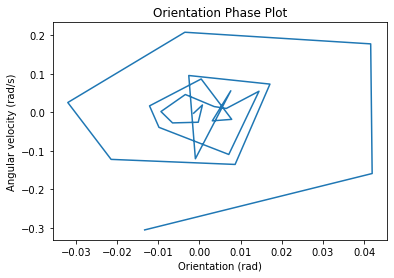

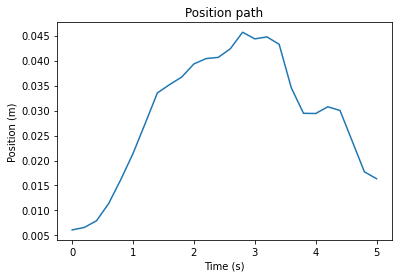

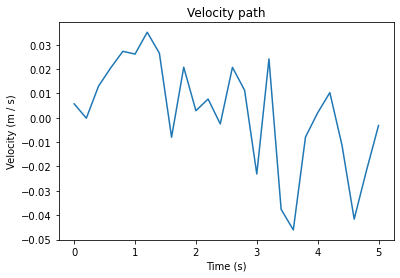

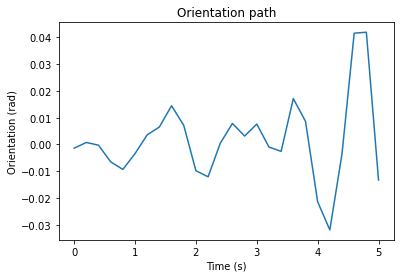

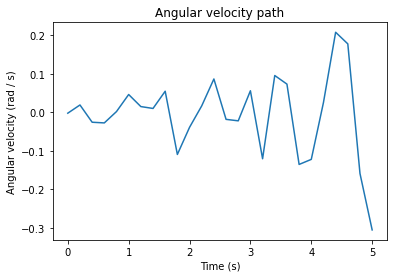

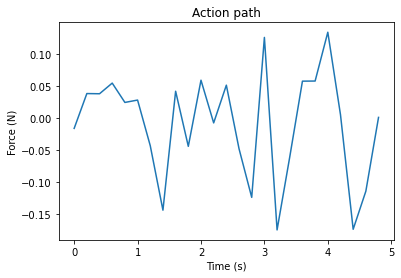

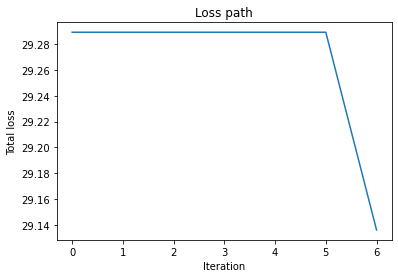

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [15]:
env.reset()
Z = torch.empty(H + 1, Z.shape[-1])
U = torch.empty(H, model.action_size)
Z[0] = env.get_state().encode(ENCODING)
for i in range(H):
    U[i] = controller(Z[i], i, ENCODING, mpc=True, u_min=U_MIN, u_max=U_MAX, on_iteration=on_iteration)
    env.apply(U[i])
    Z[i + 1] = env.get_state().encode(ENCODING)

iteration 1 iLQRState.ACCEPTED 29.143543 [ 0.01966747  0.0015057  -0.1365005  -0.32829136]
iteration 2 iLQRState.ACCEPTED 29.575909 [ 0.00519526 -0.11446236  0.12518305  0.72121304]
iteration 3 iLQRState.ACCEPTED 29.172916 [-0.03971372  0.00691879  0.6993479   0.11496115]
iteration 4 iLQRState.ACCEPTED 32.182243 [ 0.06934267  0.5826381   1.2517095  -1.0761747 ]
iteration 5 iLQRState.ACCEPTED 55.867226 [ 0.1057871  1.8900933  1.3525815 -4.25211  ]
iteration 6 iLQRState.ACCEPTED 65.878845 [ 0.1537296  2.166925  -3.0085728  4.7673798]
iteration 7 iLQRState.ACCEPTED 90.75286 [ 0.7945714  2.6167204 -2.7402651 -3.7421246]
iteration 8 iLQRState.ACCEPTED 41.9402 [-0.7613507  -0.94338185 -2.5685353   0.38006115]
iteration 9 iLQRState.REJECTED 58.690063 [-0.9578676 -1.089165  -2.1559727  3.909849 ]
iteration 9 iLQRState.REJECTED 58.690063 [-0.9578676 -1.089165  -2.1559727  3.909849 ]
iteration 9 iLQRState.ACCEPTED 56.14357 [-0.5667249 -0.7116664 -2.230722   3.706368 ]
iteration 10 iLQRState.ACCE

iteration 60 iLQRState.ACCEPTED 2.5852962 [-0.12493813 -0.09193708 -2.8864048   1.5602249 ]
iteration 61 iLQRState.ACCEPTED 2.5845644 [-0.12489457 -0.09195592 -2.886402    1.5602235 ]
iteration 62 iLQRState.ACCEPTED 2.584102 [-0.12485878 -0.09197233 -2.8864028   1.560219  ]
iteration 63 iLQRState.ACCEPTED 2.5838373 [-0.1248421  -0.09199245 -2.8864048   1.5602176 ]
iteration 64 iLQRState.ACCEPTED 2.5836806 [-0.12482865 -0.09200981 -2.8864076   1.5602163 ]
iteration 65 iLQRState.ACCEPTED 2.5835652 [-0.12481873 -0.09201562 -2.8864114   1.5602093 ]
iteration 66 iLQRState.ACCEPTED 2.5835154 [-0.12482371 -0.0920257  -2.8864162   1.5602083 ]
iteration 67 iLQRState.ACCEPTED 2.5835161 [-0.1248316  -0.09203566 -2.8864172   1.5602155 ]
iteration 68 iLQRState.ACCEPTED 2.5835032 [-0.12483327 -0.09203932 -2.88642     1.5602164 ]
iteration 69 iLQRState.ACCEPTED 2.5834877 [-0.12483778 -0.09203894 -2.886421    1.5602139 ]
iteration 70 iLQRState.ACCEPTED 2.5834956 [-0.12484765 -0.092045   -2.886422    1

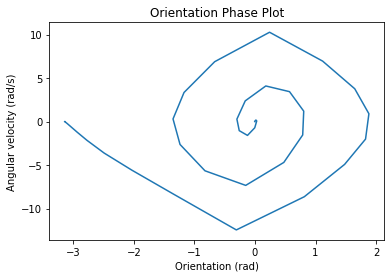

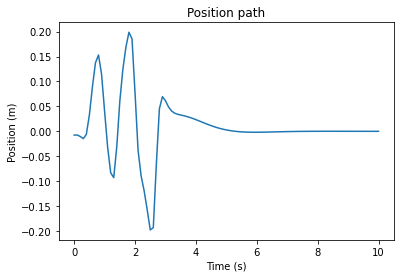

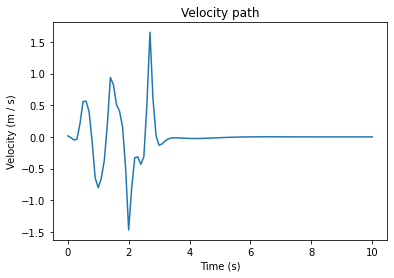

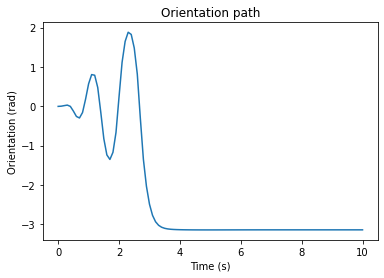

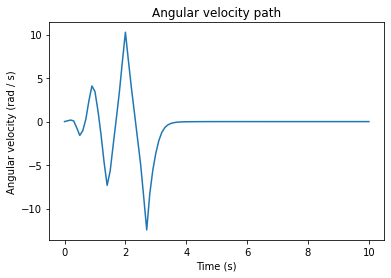

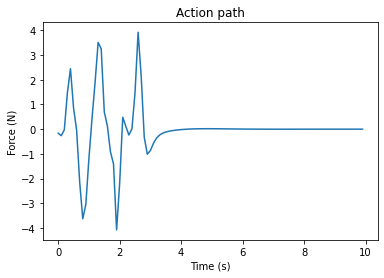

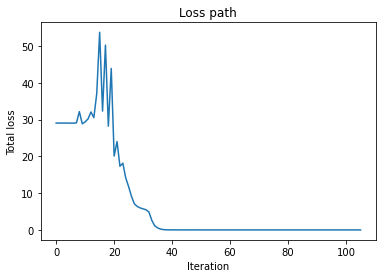

In [16]:
plot(Z, U)

In [ ]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

In [17]:
for i in range(10):
    env.apply(torch.zeros(model.action_size))

In [19]:
env.close()